In [1]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import RMSF
from MDAnalysis.analysis.rms import rmsd
from glob import glob
import itertools

In [45]:
def score_rmsd(rmsd_array, cutoff=5.0):
    
    # Find the largest number of well-aligned structures. Well-aligned means RMSD smaller than rmsd_cutoff
    well_aligned_ubs = (rmsd_array < cutoff).sum(axis=1)

    # Number of well aligned structures
    n = well_aligned_ubs.max()
    
    # Number of similarly well aligned structures
    filtered = rmsd_array[well_aligned_ubs == n]
    
    combined_rmsds = np.sqrt(np.square(filtered).sum(axis=1) / len(filtered[0]))
    best_id = np.argmin(combined_rmsds)

    return filtered[best_id]



def calc_rmsd(input_rec, debug=False, write=True):

    # Load reference structure
    u_ref = mda.Universe(input_rec["ref_PDB"])
    target_ref = u_ref.select_atoms(input_rec["ref_target"])

    # Load model structure
    model_names = glob(input_rec["model_PDBs"])
    u_model = mda.Universe(
              *model_names,
              all_coordinates = True,  # To use also the first frame.
              in_memory = True,
    )
    target_model = u_model.select_atoms(input_rec["model_target"])
    
    # Get reference and model ubiquitine atom groups.
    ub_refs = []
    ub_models = []
    for key in list(input_rec.keys()):
        if "ref_Ub" in key:
            ub_refs.append(u_ref.select_atoms(input_rec[key]))
        if "model_Ub" in key:
            ub_models.append(u_model.select_atoms(input_rec[key]))

    # Print summary of atom numbers and frames
    if debug:
        print (" Ref. Target: ", target_ref.n_atoms)
        print (" Mod. Target: ", target_model.n_atoms)
        for i,elem in enumerate(ub_refs):
            print (f" Ref. Ub{i}: ", elem.n_atoms)
        for i,elem in enumerate(ub_models):
            print (f" Mod. Ub{i}: ", elem.n_atoms)
        print (f" Found {u_ref.trajectory.n_frames} reference frames.")

    #
    # RMSD calculation startegy:
    #
    # for all models
    #   for all references
    #     align model target to ref target
    #     align model all to model target
    #     pick as RMSD_A the minimal one, RMSD_B as the second smallest, store the pair
    #   pick the pair with the best combined RMSD = sqrt( RMSD_A^2 / 2 + RMSD_B^2 /2)
    #
    
    if len(ub_models) <= len(ub_refs):
        permuted = list(itertools.permutations(ub_refs))
        permuted = list(set([ elem[:len(ub_models)] for elem in permuted ]))
        rmsd_len = len(ub_models)
        fixed = ub_models
    else:
        permuted = list(itertools.permutations(ub_models))
        permuted = list(set([ elem[:len(ub_refs)] for elem in permuted ]))
        rmsd_len = len(ub_refs)
        fixed = ub_refs
    print (f" Can create {len(permuted)} unique assignments per reference frame.")
    
    # Store results
    all_target_rmsd = np.zeros(len(model_names))
    all_ub_rmsd     = np.zeros((len(model_names), rmsd_len))
    for ts_model in u_model.trajectory:
        
        # Store all best-Ub-RMSD-pair for all reference combinations
        ub_rmsd_for_all_refs = np.zeros((u_ref.trajectory.n_frames, rmsd_len))

        for ts_ref in u_ref.trajectory:
            # Align target in model onto target in reference
            #  Step 1: Align target_model onto target_ref
            align.alignto(target_model, target_ref, select="all", match_atoms=False)
            #  Step 2: Align u_model onto target_model
            align.alignto(u_model, target_model, select=input_rec["model_target"], match_atoms=False)
            
            # Compute RMSDs
            #  Step 1: Target vs target
            target_rmsd = rmsd(target_model.positions, target_ref.positions, center=False, superposition=False)
            #  Step 2: Compare all model Ubs vs all ref Ubs. They can differ in their number

            ub_perm_rmsds = np.zeros((len(permuted), len(fixed)))
            for i, perm in enumerate(permuted):
                for j,fp in enumerate(zip(fixed,perm)):
                    f = fp[0]
                    p = fp[1]
                    # print (f.segids[0], "-", p.segids[0], end='   ')
                    ub_perm_rmsds[i,j] = rmsd(f.positions, p.positions, center=False, superposition=False)
            
            ub_rmsd_for_all_refs[ts_ref.frame] = score_rmsd(ub_perm_rmsds)
            
        # Determine minimal overall diUb RMSD for all the entries, and select the minimal.
        combined_rmsds = np.sqrt(np.square(ub_rmsd_for_all_refs).sum(axis=1) / len(ub_rmsd_for_all_refs[0]))
        best_ref_id = np.argmin(combined_rmsds)
            
        all_target_rmsd[ts_model.frame] = target_rmsd
        all_ub_rmsd[ts_model.frame]     = ub_rmsd_for_all_refs[best_ref_id]

    u_model.atoms.write(f"{input_rec['aligned_model']}", frames='all')

    return model_names, all_target_rmsd, all_ub_rmsd


In [52]:
input_rec_dic={
  "5ymy":
      {
       "ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",  # DISTAL
       "model_PDBs"   : "5ymy/5*pdb",
       "model_target" : "chainID E and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "5ymy/aligned-5ymy.pdb",
      },
  "5ymy-bond":
      {"ref_PDB"      : "references/5ymy.pdb",
       "ref_target"   : "chainID C and name CA and resnum 19:132",
       "ref_Ub1"      : "chainID A and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "5ymy-bond/5*pdb",
       "model_target" : "chainID E and name CA and resnum 19:132",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "5ymy-bond/aligned-5ymy-bond.pdb",
      },
  "6isu":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "6isu/6*pdb",
       "model_target" : "chainID E and name CA and resnum 4:230",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "6isu/aligned-6isu.pdb",
      },
  "6isu-bond":
      {"ref_PDB"      : "references/6isu.pdb",
       "ref_target"   : "chainID A and name CA and resnum 4:230",
       "ref_Ub1"      : "chainID C and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA",   # DISTAL
       "model_PDBs"   : "6isu-bond/6*pdb",
       "model_target" : "chainID E and name CA and resnum 4:230",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "6isu-bond/aligned-6isu-bond.pdb",
      },
  "6tuv":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "6tuv/6*pdb",
       "model_target" : "chainID E and name CA and resnum 1:260",
       "model_Ub1"    : "chainID A and name CA and resnum 1:71",
       "model_Ub2"    : "chainID B and name CA and resnum 1:71",
       "aligned_model": "6tuv/aligned-6tuv.pdb",
      },
  "6tuv-bond":
      {"ref_PDB"      : "references/6tuv.pdb",
       "ref_target"   : "chainID A and name CA and resnum 110:369",
       "ref_Ub1"      : "chainID H and name CA and resnum 1:71",  # PROXIMAL
       "ref_Ub2"      : "chainID D and name CA and resnum 1:71",  # DISTAL
       "model_PDBs"   : "6tuv-bond/6*pdb",
       "model_target" : "chainID E and name CA and resnum 1:260",
       "model_Ub1"    : "chainID A and name CA and resnum 1:71",
       "model_Ub2"    : "chainID B and name CA and resnum 1:71",
       "aligned_model": "6tuv-bond/aligned-6tuv-bond.pdb",
      },
  "6ud0":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "6ud0/6*pdb",
       "model_target" : "chainID E and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "6ud0/aligned-6ud0.pdb",
      },
  "6ud0-bond":
      {"ref_PDB"      : "references/6ud0.pdb",
       "ref_target"   : "chainID C and name CA and resnum 3:143",
       "ref_Ub1"      : "chainID A and name CA and resnum 1:76",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:76",  # DISTAL
       "model_PDBs"   : "6ud0-bond/6*pdb",
       "model_target" : "chainID E and name CA and resnum 3:143",
       "model_Ub1"    : "chainID A and name CA and resnum 1:76",
       "model_Ub2"    : "chainID B and name CA and resnum 1:76",
       "aligned_model": "6ud0-bond/aligned-6ud0-bond.pdb",
      },
  "7keo":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "7keo/7*pdb",
       "model_target" : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID A and name CA and resnum 1:72", 
       "model_Ub2"    : "chainID B and name CA and resnum 1:72",
       "aligned_model": "7keo/aligned-7keo.pdb",
      },
  "7keo-bond":  # has two target chains!
      {"ref_PDB"      : "references/7keo.pdb",
       "ref_target"   : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "ref_Ub1"      : "chainID G and name CA and resnum 1:72",  # PROXIMAL
       "ref_Ub2"      : "chainID H and name CA and resnum 1:72",
       "model_PDBs"   : "7keo-bond/7*pdb",
       "model_target" : "(chainID E and resnum 5:229) or (chainID F and resnum 2:215) and name CA",
       "model_Ub1"    : "chainID A and name CA and resnum 1:72",
       "model_Ub2"    : "chainID B and name CA and resnum 1:72",
       "aligned_model": "7keo-bond/aligned-7keo-bond.pdb",
      },
  "7m4n":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA",   # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "7m4n/7*pdb",
       "model_target" : "chainID E and name CA and resnum 4:114",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "7m4n/aligned-7m4n.pdb",
      },
  "7m4n-bond":
      {"ref_PDB"      : "references/7m4n.pdb",
       "ref_target"   : "chainID A and name CA and resnum 652:762",
       "ref_Ub1"      : "chainID E and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA",
       "model_PDBs"   : "7m4n-bond/7*pdb",
       "model_target" : "chainID E and name CA and resnum 4:114",
       "model_Ub1"    : "chainID A and name CA",
       "model_Ub2"    : "chainID B and name CA",
       "aligned_model": "7m4n-bond/aligned-7m4n-bond.pdb",
      },
  "7uv5":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : "7uv5/7*pdb",
       "model_target" : "chainID E and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID A and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": "7uv5/aligned-7uv5.pdb",
      },
  "7uv5-bond":
      {"ref_PDB"      : "references/7uv5.pdb",
       "ref_target"   : "chainID A and resnum 4:315 and name CA and not altLoc B",
       "ref_Ub1"      : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",  # PROXIMAL
       "ref_Ub2"      : "chainID C and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_PDBs"   : "7uv5-bond/7*pdb",
       "model_target" : "chainID E and resnum 4:315 and name CA and not altLoc B",
       "model_Ub1"    : "chainID A and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "model_Ub2"    : "chainID B and (resnum 1:2 or resnum 7:11 or resnum 17:19 or resnum 23:29 or resnum 35:50 or resnum 66:73) and name CA",
       "aligned_model": "7uv5-bond/aligned-7uv5-bond.pdb",
      },
  "7uyh":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "7uyh/7*pdb",
       "model_target" : "chainID E and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "7uyh/aligned-7uyh.pdb",
      },
  "7uyh-bond":
      {"ref_PDB"      : "references/7uyh.pdb",
       "ref_target"   : "chainID A and name CA and resnum 1:276",
       "ref_Ub1"      : "chainID C and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID B and name CA and resnum 1:75",
       "model_PDBs"   : "7uyh-bond/7*pdb",
       "model_target" : "chainID E and name CA and resnum 1:276",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "7uyh-bond/aligned-7uyh-bond.pdb",
      },
  "8c61":
      {"ref_PDB"      : "references/8c61.pdb",
       "ref_target"   : "chainID A and name CA and resnum 29:198 206:358",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:75",
       "ref_Ub3"      : "chainID F and name CA and resnum 1:75",
       "ref_Ub4"      : "chainID I and name CA and resnum 1:75",
       "model_PDBs"   : "8c61/8*pdb",
       "model_target" : "chainID E and name CA and resnum 9:178 186:338",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "8c61/aligned-8c61.pdb",
      },
  "8c61-bond":
      {"ref_PDB"      : "references/8c61.pdb",
       "ref_target"   : "chainID A and name CA and resnum 29:198 206:358",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:75",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:75",
       "ref_Ub3"      : "chainID F and name CA and resnum 1:75",
       "ref_Ub4"      : "chainID I and name CA and resnum 1:75",
       "model_PDBs"   : "8c61-bond/8*pdb",
       "model_target" : "chainID E and name CA and resnum 9:178 186:338",
       "model_Ub1"    : "chainID A and name CA and resnum 1:75",
       "model_Ub2"    : "chainID B and name CA and resnum 1:75",
       "aligned_model": "8c61-bond/aligned-8c61-bond.pdb",
      },
  "9avt":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",   # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "9avt/9*pdb",
       "model_target" : "chainID E and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt/aligned-9avt.pdb",
      },
  "9avt-bond":
      {"ref_PDB"      : "references/9avt.pdb",
       "ref_target"   : "chainID C and name CA and resnum 664:693 and not altLoc B",
       "ref_Ub1"      : "chainID B and name CA and resnum 1:73    and not altLoc B",  # PROXIMAL
       "ref_Ub2"      : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_PDBs"   : "9avt-bond/9*pdb",
       "model_target" : "chainID E and name CA and resnum 1:30    and not altLoc B",
       "model_Ub1"    : "chainID A and name CA and resnum 1:73    and not altLoc B",
       "model_Ub2"    : "chainID B and name CA and resnum 1:73    and not altLoc B",
       "aligned_model": "9avt-bond/aligned-9avt-bond.pdb",
    },
  "8j1p":
      {"ref_PDB"      : "references/8j1p.pdb",
       "ref_target"   : "chainID A and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "ref_Ub1"      : "chainID D and name CA and resnum 1:74",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:74",
       "ref_Ub3"      : "chainID E and name CA and resnum 1:74",
       "model_PDBs"   : "8j1p/8*pdb",
       "model_target" : "chainID E and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "model_Ub1"    : "chainID A and name CA and resnum 1:74",
       "model_Ub2"    : "chainID B and name CA and resnum 1:74",
       "model_Ub3"    : "chainID C and name CA and resnum 1:74",       
       "aligned_model": "8j1p/aligned-8j1p.pdb",
      },
  "8j1p-bond":
      {"ref_PDB"      : "references/8j1p.pdb",
       "ref_target"   : "chainID A and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "ref_Ub1"      : "chainID D and name CA and resnum 1:74",  # PROXIMAL
       "ref_Ub2"      : "chainID C and name CA and resnum 1:74",
       "ref_Ub3"      : "chainID E and name CA and resnum 1:74",
       "model_PDBs"   : "8j1p-bond/8*pdb",
       "model_target" : "chainID E and name CA and resnum 164:654 664:705 711:839 848:876 905:956 970:1078 1086:1167 1178:1477",
       "model_Ub1"    : "chainID A and name CA and resnum 1:74",
       "model_Ub2"    : "chainID B and name CA and resnum 1:74",
       "model_Ub3"    : "chainID C and name CA and resnum 1:74",       
       "aligned_model": "8j1p-bond/aligned-8j1p-bond.pdb",
      },
}

In [53]:
# Compute RMSDs

result_target_dict = {}
result_diub_dict = {}
result_monoub_dict = {}
for system in input_rec_dic.keys():
    print (system)
    model_names, target_rmsd, ub_rmsd = calc_rmsd(input_rec=input_rec_dic[system], debug = True)
    result_target_dict[system] = target_rmsd
    # USE IF THE UB RMSD-S ARE COMBINED
    result_diub_dict[system] = np.sqrt(np.square(ub_rmsd).sum(axis=1) / len(ub_rmsd[0]))
    for i,col in enumerate(ub_rmsd.T): 
        result_monoub_dict[system+f"-{i}"] = col
    print ()

5ymy


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:728: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


 Ref. Target:  114
 Mod. Target:  114
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 20 reference frames.
 Can create 2 unique assignments per reference frame.


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"



5ymy-bond
 Ref. Target:  114
 Mod. Target:  114
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 20 reference frames.
 Can create 2 unique assignments per reference frame.

6isu
 Ref. Target:  227
 Mod. Target:  227
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.

6isu-bond
 Ref. Target:  227
 Mod. Target:  227
 Ref. Ub0:  76
 Ref. Ub1:  76
 Mod. Ub0:  76
 Mod. Ub1:  76
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.

6tuv
 Ref. Target:  260
 Mod. Target:  260
 Ref. Ub0:  71
 Ref. Ub1:  71
 Mod. Ub0:  71
 Mod. Ub1:  71
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.

6tuv-bond
 Ref. Target:  260
 Mod. Target:  260
 Ref. Ub0:  71
 Ref. Ub1:  71
 Mod. Ub0:  71
 Mod. Ub1:  71
 Found 1 reference frames.
 Can create 2 unique assignments per reference frame.

6ud0
 Ref. Target:  141
 Mod. Target:  141
 Ref. Ub0:  76


/home/tb/bafabian/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


 Ref. Target:  1234
 Mod. Target:  1234
 Ref. Ub0:  74
 Ref. Ub1:  74
 Ref. Ub2:  74
 Mod. Ub0:  74
 Mod. Ub1:  74
 Mod. Ub2:  74
 Found 1 reference frames.
 Can create 6 unique assignments per reference frame.

8j1p-bond
 Ref. Target:  1234
 Mod. Target:  1234
 Ref. Ub0:  74
 Ref. Ub1:  74
 Ref. Ub2:  74
 Mod. Ub0:  74
 Mod. Ub1:  74
 Mod. Ub2:  74
 Found 1 reference frames.
 Can create 6 unique assignments per reference frame.



In [54]:
# Transfrom the AF3 model data to pandas DataFrame suitable for seaborn plotting

import pandas as pd

target_rmsd_df = pd.DataFrame (result_target_dict)
target_rmsd_df = target_rmsd_df.melt(var_name='PDB', value_name='RMSD')
target_rmsd_df['bond'] = target_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
target_rmsd_df['PDB']  = target_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

diub_rmsd_df = pd.DataFrame (result_diub_dict)
diub_rmsd_df = diub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
diub_rmsd_df['bond'] = diub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
diub_rmsd_df['PDB']  = diub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)

monoub_rmsd_df = pd.DataFrame (result_monoub_dict)
monoub_rmsd_df = monoub_rmsd_df.melt(var_name='PDB', value_name='RMSD')
monoub_rmsd_df['bond'] = monoub_rmsd_df['PDB'].apply(lambda x: 'yes' if 'bond' in x else 'no')
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.replace('-bond', '', regex=True)
monoub_rmsd_df['Ub-ID'] = monoub_rmsd_df['PDB'].apply(lambda x: x[-1])
monoub_rmsd_df['PDB']  = monoub_rmsd_df['PDB'].str.slice(0, -2)
print (monoub_rmsd_df)

        PDB       RMSD bond Ub-ID
0      5ymy   7.752867   no     0
1      5ymy   7.454366   no     0
2      5ymy  32.011612   no     0
3      5ymy  43.060288   no     0
4      5ymy  31.847516   no     0
...     ...        ...  ...   ...
22995  8j1p   7.082943  yes     2
22996  8j1p   6.011000  yes     2
22997  8j1p   7.031400  yes     2
22998  8j1p   8.488821  yes     2
22999  8j1p   6.781896  yes     2

[23000 rows x 4 columns]


(-0.5, 9.5)


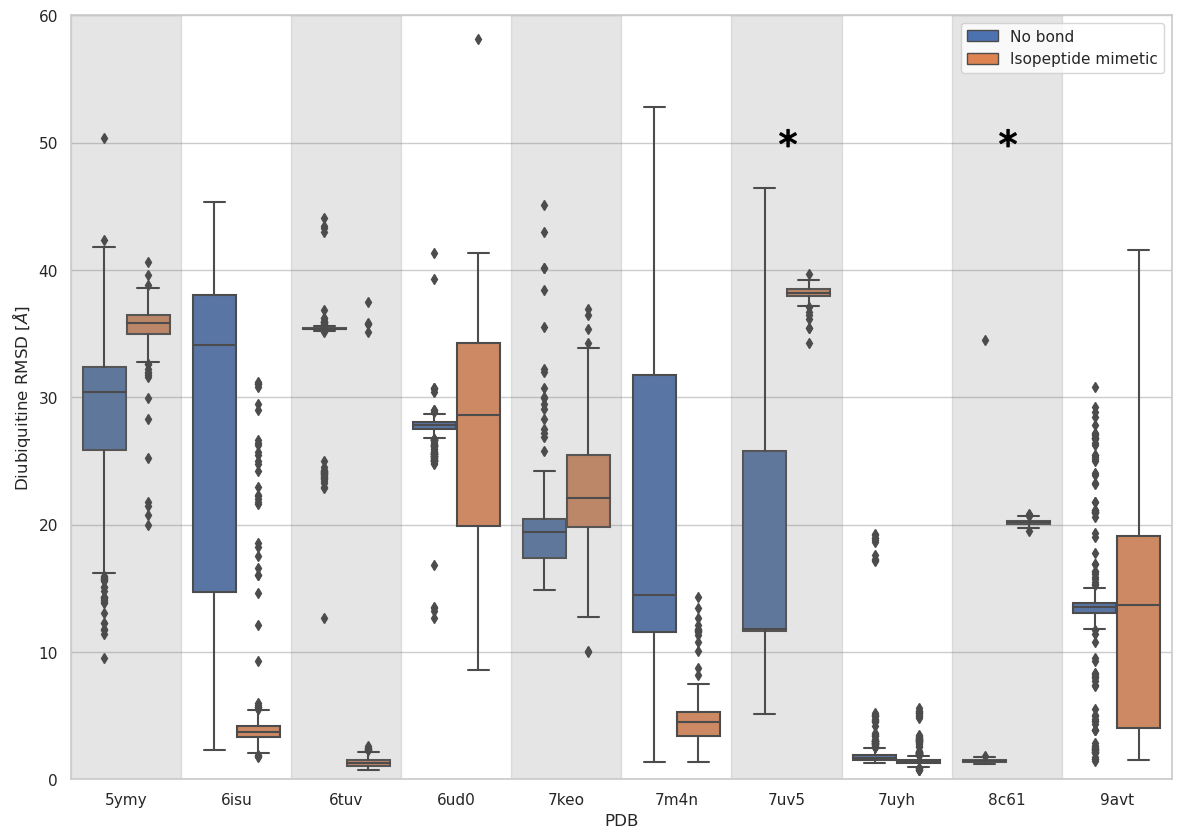

In [55]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn
plt.rcParams['svg.fonttype'] = 'none'
# Get the default color palette
colors = seaborn.color_palette()

fig = plt.figure(layout="constrained")
 
# use to set style of background of plot
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")


ax = seaborn.boxplot(x="PDB", y="RMSD", hue="bond", data=diub_rmsd_df[diub_rmsd_df['PDB'] != '8j1p'])
ax.set_ylabel(r'Diubiquitine RMSD [$\AA$]')
ax.legend(title='Using bond?', labels=['No', 'Yes'])
ax.set_ylim([0,60])
ax.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
leg = ax.get_legend()
leg.legendHandles[0].set_facecolor(colors[0])
leg.legendHandles[1].set_facecolor(colors[1])
leg.legendHandles[0].set_linewidth(1)
leg.legendHandles[1].set_linewidth(1)

limits = ax.get_xlim()
print (limits)
ax.axvspan(-0.5, 0.5, color='gray', alpha=0.2)
ax.axvspan( 1.5, 2.5, color='gray', alpha=0.2)
ax.axvspan( 3.5, 4.5, color='gray', alpha=0.2)
ax.axvspan( 5.5, 6.5, color='gray', alpha=0.2)
ax.axvspan( 7.5, 8.5, color='gray', alpha=0.2)
ax.set_xlim(limits)
plt.plot([6], [50], marker=r'$*$', markersize=20, color="black")
plt.plot([8], [50], marker=r'$*$', markersize=20, color="black")


plt.savefig("AF3-diub-rmsd.svg", bbox_inches=0, transparent=True)
plt.savefig("AF3-diub-rmsd.png", bbox_inches=0, transparent=False)


plt.show()

0 0
0 3
1 0
1 3
2 0
2 3
3 0
3 3
4 0
4 3


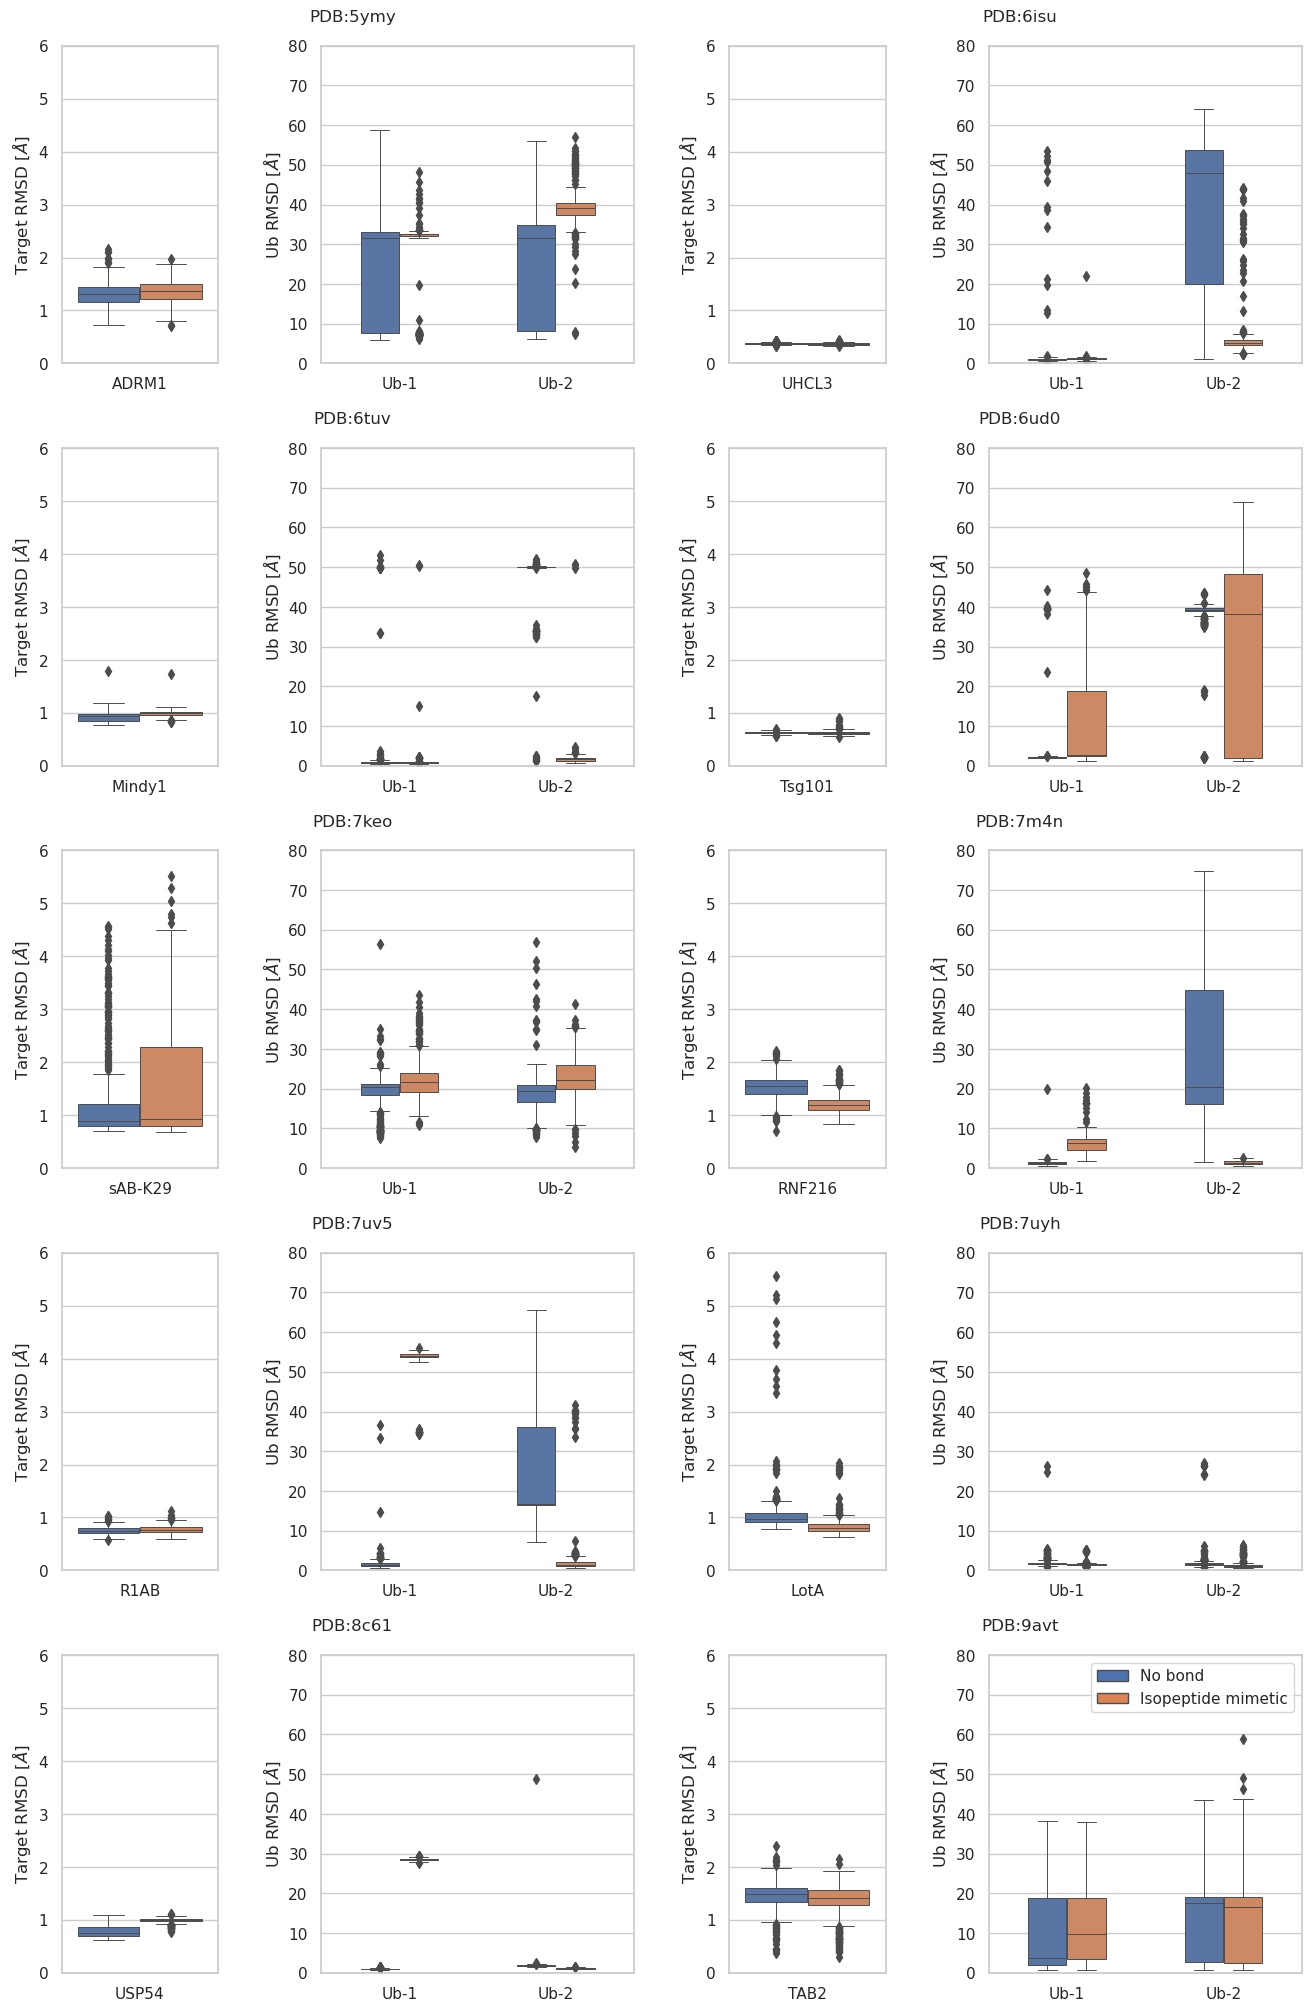

In [56]:
# use to set style of background of plot
plt.rcParams['svg.fonttype'] = 'none'
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# Get the default color palette
colors = seaborn.color_palette()

pdb_names = '5ymy','6isu','6tuv','6ud0','7keo','7m4n','7uv5','7uyh','8c61','9avt'
protein_names = 'ADRM1', 'UHCL3', 'Mindy1', 'Tsg101', 'sAB-K29', 'RNF216', 'R1AB', 'LotA', 'USP54', 'TAB2'

fig = plt.figure(layout="constrained", figsize=(13,20))
gs = GridSpec(5, 6, figure=fig, wspace=0.2, hspace=0.05)


cnt = 0
for pdb, protein in zip(pdb_names, protein_names):

    
    # Get column and row from cnt
    row = int(cnt/2)
    col = (cnt % 2) * 3
    
    print (row,col)
    
    ax1 = fig.add_subplot(gs[row, col])
    ax2 = fig.add_subplot(gs[row, col+1:col+3])
    ax2.set_title(f"PDB:{pdb}", x=0.1, y=1.05)

    seaborn.boxplot(x="PDB", y="RMSD", hue="bond", data=target_rmsd_df[target_rmsd_df['PDB'] == pdb], ax=ax1, linewidth=0.7)
    ax1.set_ylabel(r'Target RMSD [$\AA$]')
    ax1.set_xticklabels([protein,])
    ax1.set_ylim([0,6])
    ax1.set_xlabel(None)
    legend = ax1.legend()
    legend.remove()
    
    

    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    seaborn.boxplot(x="Ub-ID", y="RMSD", hue="bond", data=data, ax=ax2, width=0.5, linewidth=0.7)
    ax2.set_ylabel(r'Ub RMSD [$\AA$]')
    if pdb == '8j1p':
        ax2.set_xticklabels([r"Ub-1", r"Ub-2", r"Ub-3"])
    else:
        ax2.set_xticklabels([r"Ub-1", r"Ub-2"])
    if cnt==9:
        ax2.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
        leg = ax2.get_legend()
        leg.legendHandles[0].set_facecolor(colors[0])
        leg.legendHandles[1].set_facecolor(colors[1])
        leg.legendHandles[0].set_linewidth(1)
        leg.legendHandles[1].set_linewidth(1)
    else:
        legend = ax2.legend()
        legend.remove()
        
    ax2.set_xlabel(None)
    ax2.set_ylim([0,80])
    
    cnt += 1


plt.savefig(f"AF3-si-panel.svg", bbox_inches=0, transparent=True)
plt.savefig(f"AF3-si-panel.png", bbox_inches=0, transparent=False)
plt.show()

0 0


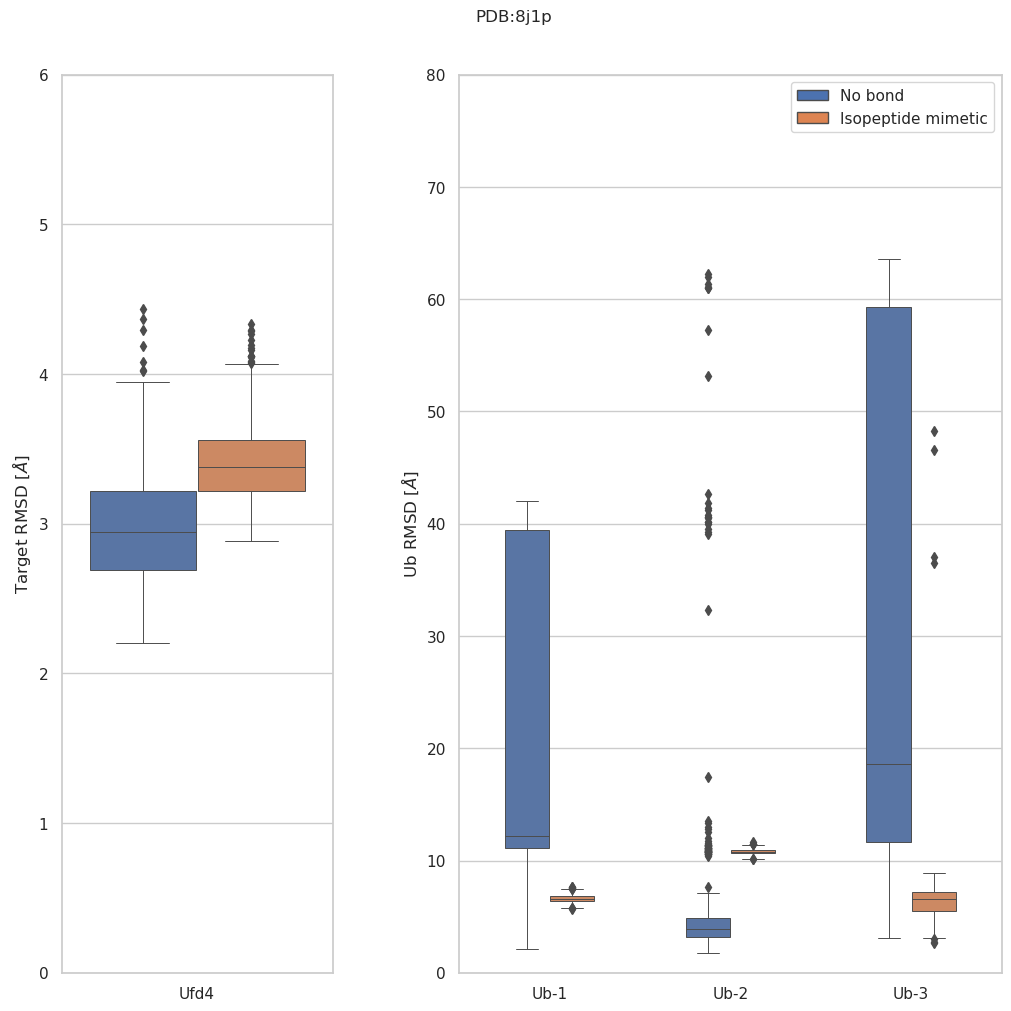

In [59]:
# use to set style of background of plot
plt.rcParams['svg.fonttype'] = 'none'
seaborn.set_theme(rc={'figure.figsize':(11.7,8.27)})
seaborn.set(style="whitegrid")

# Get the default color palette
colors = seaborn.color_palette()

pdb_names = '8j1p',
protein_names = 'Ufd4',
fig = plt.figure(layout="constrained", figsize=(10,10))
gs = GridSpec(1, 3, figure=fig, wspace=0.2, hspace=0.05)


cnt = 0
for pdb, protein in zip(pdb_names, protein_names):

    
    # Get column and row from cnt
    row = int(cnt/2)
    col = (cnt % 2) * 3
    
    print (row,col)
    
    ax1 = fig.add_subplot(gs[row, col])
    ax2 = fig.add_subplot(gs[row, col+1:col+3])
    ax2.set_title(f"PDB:{pdb}", x=0.1, y=1.05)

    seaborn.boxplot(x="PDB", y="RMSD", hue="bond", data=target_rmsd_df[target_rmsd_df['PDB'] == pdb], ax=ax1, linewidth=0.7)
    ax1.set_ylabel(r'Target RMSD [$\AA$]')
    ax1.set_xticklabels([protein,])
    ax1.set_ylim([0,6])
    ax1.set_xlabel(None)
    legend = ax1.legend()
    legend.remove()
    
    data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
    seaborn.boxplot(x="Ub-ID", y="RMSD", hue="bond", data=data, ax=ax2, width=0.5, linewidth=0.7)
    ax2.set_ylabel(r'Ub RMSD [$\AA$]')
    if pdb == '8j1p':
        ax2.set_xticklabels([r"Ub-1", r"Ub-2", r"Ub-3"])
    else:
        ax2.set_xticklabels([r"Ub-1", r"Ub-2"])
    if cnt==0:
        ax2.legend(title=None, labels=['No bond', 'Isopeptide mimetic'])
        leg = ax2.get_legend()
        leg.legendHandles[0].set_facecolor(colors[0])
        leg.legendHandles[1].set_facecolor(colors[1])
        leg.legendHandles[0].set_linewidth(1)
        leg.legendHandles[1].set_linewidth(1)
    else:
        legend = ax2.legend()
        legend.remove()
        
    ax2.set_xlabel(None)
    ax2.set_ylim([0,80])
    
    cnt += 1


plt.savefig(f"SI-Figure3-AF5-8j1p.svg", bbox_inches=0, transparent=True)
plt.savefig(f"SI-Figure3-AF5-8j1p.png", bbox_inches=0, transparent=False)
plt.show()

In [86]:
pdb = '8j1p'
target = target_rmsd_df[target_rmsd_df['PDB'] == pdb]
target = target[target['bond'] == 'yes']
print (target['RMSD'].mean(), " +/- ", target['RMSD'].std())

data = monoub_rmsd_df[monoub_rmsd_df['PDB'] == pdb]
data = data[data['bond'] == 'yes']

for i in range(3):
    print (data[data['Ub-ID'] == str(i)]['RMSD'].mean(), " +/- ", data[data['Ub-ID'] == str(i)]['RMSD'].std())

3.425258659663807  +/-  0.2828942142999376
6.629556448057785  +/-  0.34634105548718874
10.795928138768803  +/-  0.24778846218010386
6.466393195667746  +/-  3.5108565858767298
